<h1 align=center><font size = 5>Chinese Restaurants in New York City (Week - 1)</font></h1>

## Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many restaurants in New york City, each belonging to different categories like Chinese , Italian, Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Chinese restaurants.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Datasets</a>

2. <a href="#item2">Approach</a>

3. <a href="#item3">Questions that can be answered using the above datasets</a>

4. <a href="#item4">Analysis</a>

   
</font>
</div>

## 1. Datasets

Data
For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
Chinese restaurants in each neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Chinese restaurants.
GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

## 2. Approach

 - Collect the new york city data from https://cocl.us/new_york_dataset
 - Using FourSquare API we will find all venues for each neighborhood.
 - Filter out all venues that are Chinese Restaurants.
 - Find rating , tips and like count for each Chinese Restaurants using FourSquare API.
 - Using rating for each restaurant , we will sort that data.
 - Visualize the Ranking of neighborhoods using folium library(python)

## 3. Questions that can be answered using the above datasets

 - What is best location in New York City for Chinese Cuisine ?
 - Which areas have potential Chinese Restaurant Market ?
 - Which all areas lack Chinese Restaurants ?
 - Which is the best place to stay if I prefer Chinese Cuisine ?

## 4. Analysis

## 1. Datasets

### Required Libraries

 - pandas and numpy for handling data.
 - request module for using FourSquare API.
 - geopy to get co-ordinates of City of New York.
 - folium to visualize the results on a map

In [35]:
# User credentials
CLIENT_ID = 'LU3414NYO355MM5D0VY0E2JJZ1BSAHMZLSLZEMN32J1C2PQ0' # changed my Foursquare ID
CLIENT_SECRET = '1ILFEN1U0EZNSDZDKSWFPTQ4MOTGY0YFW5SGSPPU4HA112YH' # changed Foursquare Secret
#CLIENT_ID = 'IVAWQVAMA3EF1ZP5PEAGSXKBXUSQJKSFUJ5PCUTF4G0PPPI4' # changed my Foursquare ID
#CLIENT_SECRET = 'ITHRH4SP5QFNWQIB0A221WOYUKLZUDKYIJPNMA1OWGZX5XOV' # changed Foursquare Secret

In [2]:
pip install beautifulsoup4

     |████████████████████████████████| 112kB 28.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

     |████████████████████████████████| 112kB 2.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geocoder

     |████████████████████████████████| 102kB 5.4MB/s ta 0:00:011
     |████████████████████████████████| 829kB 8.8MB/s eta 0:00:01
     |████████████████████████████████| 92kB 22.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim 
import requests


print('Libraries imported.')

Libraries imported.


Define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [37]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [51]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    VERSION = '20200326' # Foursquare API version
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [41]:
def get_venue_details(venue_id):
        
    VERSION = '20200326' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


The above function will be called to get the new york city data.

In [11]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
new_york_data.shape

(306, 4)

#### There are total 306 places in New York which need to be searched for the restaurants.

#### Save the all restaurent in New York data as .csv file for further use

In [13]:
new_york_data.to_csv('new_york_data_before_filter.csv')

In [71]:
new_york_data_1 = pd.read_csv("new_york_data_before_filter.csv")
new_york_data_1.drop(['Unnamed: 0'], axis=1, inplace=True)
new_york_data_1.shape
new_york_data_1.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [72]:
#b=new_york_data_1.groupby('Latitude').count()

#b=np.unique(new_york_data_1['Longitude'], axis=0)
#b.shape

In [53]:
#new_york_data_1.duplicated()

#### Plot of Number of Neighborhood with respect to Borough in New York City

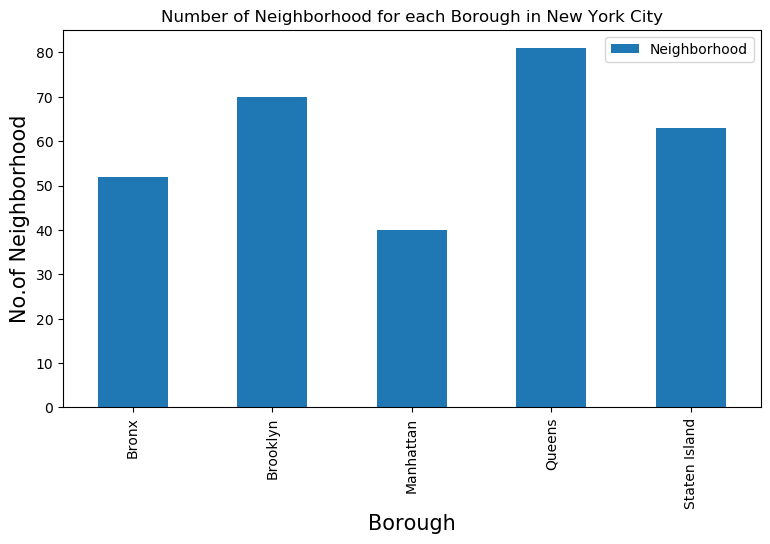

In [54]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

 #### Queens has highest number of neighborhoods

#### Now we will collect informations of Chinese restaurants for each Neighborhood

In [55]:
# prepare neighborhood list that contains chinese restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) chinese Resturants in Wakefield, Bronx:1
done
( 2 / 306 ) chinese Resturants in Co-op City, Bronx:1
done
( 3 / 306 ) chinese Resturants in Eastchester, Bronx:1
done
( 4 / 306 ) chinese Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) chinese Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) chinese Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) chinese Resturants in Marble Hill, Manhattan:1
done
( 8 / 306 ) chinese Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) chinese Resturants in Norwood, Bronx:2
done
( 10 / 306 ) chinese Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) chinese Resturants in Baychester, Bronx:3
done
( 12 / 306 ) chinese Resturants in Pelham Parkway, Bronx:3
done
( 13 / 306 ) chinese Resturants in City Island, Bronx:1
done
( 14 / 306 ) chinese Resturants in Bedford Park, Bronx:2
done
( 15 / 306 ) chinese Resturants in University Heights, Bronx:1
done
( 16 / 306 ) chinese Resturants in Morris Heights, Bronx:3
done
( 17 / 306 ) chinese R

In [56]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
2,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
3,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant


In [57]:
chinese_rest_ny.shape

(410, 4)

#### Save the all data of Chinese restaurents in New York as .csv file for further use

In [21]:
chinese_rest_ny.to_csv('chinese_rest_ny.csv')

In [67]:
chinese_rest_ny = pd.read_csv("chinese_rest_ny.csv")
chinese_rest_ny_1 = pd.read_csv("chinese_rest_ny.csv")
chinese_rest_ny_1.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
2,2,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
3,3,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet
4,4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant


#### Filter the data of Chinese restaurents in New York for the duplicates 

In [68]:
c=chinese_rest_ny_1['Name'].duplicated()
#d=chinese_rest_ny_1.drop_duplicates(['Name'], keep='last')
chinese_rest_ny_1.drop_duplicates(subset ="Name", 
                     keep = False, inplace = True)

In [69]:
chinese_rest_ny_1.shape

(214, 5)

In [70]:
chinese_rest_ny_1.drop(['Unnamed: 0'], axis=1, inplace=True)
chinese_rest_ny_1.shape

(214, 4)

#### There are total 214 different Chinese restaurants in the New York City

#### Now we will mark all Chinese restaurants on New York map

In [73]:
ny_neighborhood =pd.merge(chinese_rest_ny_1,new_york_data_1, on='Neighborhood')
ny_neighborhood.head()

,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude
0,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,Bronx,40.874294,-73.829939
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,Bronx,40.887556,-73.827806
2,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet,Manhattan,40.876551,-73.910660
3,Bronx,Baychester,4c1a8bac8b3aa593a8c8955f,Dragon City,Bronx,40.866858,-73.835798
4,Bronx,Baychester,4eadecbf9911d5c95181ee84,Yummy House,Bronx,40.866858,-73.835798


In [84]:
locations = ny_neighborhood[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
len(locationlist)
#locationlist[1]

218

#### The location list will be used to markdown on the Folium map

In [92]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [94]:
import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np
import folium
print('Libraries imported')

Libraries imported


In [95]:
map = folium.Map(location=[42.937084, -75.6107], zoom_start=5)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=ny_neighborhood['Name'][point]).add_to(map)
map

In [98]:
map.save("map.jpeg")

## To be continued in "Battle of Neighborhood Week- 2"